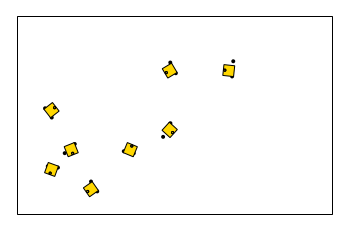

AttributeError: module 'rps.utilities.transformations' has no attribute 'create_single_integrator_to_unicycle'

<Figure size 432x288 with 0 Axes>

In [8]:
# Robotarium example: formation preservation and cyclic pursuit with two subteams
# @author Anqi Li
# @date April 8, 2019

import rps.robotarium as robotarium
import rps.utilities.graph as graph
import rps.utilities.transformations as transformations
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import at_pose

import time

import numpy as np
from numpy.linalg import norm

from rmp import RMPRoot, RMPNode
from rmp_leaf import CollisionAvoidanceDecentralized, GoalAttractorUni, FormationDecentralized

from matplotlib import pyplot as plt

# Instantiate Robotarium object

# number of robots
N = 5 + 3
N_cyclic_pursuit = 5
cyclic_pursuit_index = [i for i in range(N_cyclic_pursuit)]
formation_control_index = [5, 6, 7]
goal_2_goal_index = 5

# goal configurations
theta = np.arange(N) * 2 * np.pi / N_cyclic_pursuit
x_g = np.stack((np.cos(theta), np.sin(theta))).T * 0.8
x_g[-3, :] = np.array([-0.8, -0.8])
x_g[-2, :] = np.array([-0.8, -1.3])
x_g[-1, :] = np.array([-1.3, -0.8])


# initialize the robotarium
#rb = robotarium.Robotarium(number_of_agents=N, show_figure=True, save_data=False, update_time=0.1)
rb = robotarium.Robotarium(N, show_figure=True)

# the algorithm uses single-integrator dynamics, so we'll need these mappings.
si_to_uni_dyn, uni_to_si_states = transformations.create_single_integrator_to_unicycle(projection_distance=0.04)


# barrier certificate to avoid collisions. used for driving to the initial configs, 
# not used during the algorthim
si_barrier_cert = create_single_integrator_barrier_certificate(N)

def at_position(states, poses, position_error=0.01):
    pes = norm(states[:2, :] - poses[:2, :], 2, axis=0)
    done = np.nonzero(pes <= position_error)
    return done

# --------------------------------------------------------------------------------------
# build the RMPtree

r = RMPRoot('root')

robots = []


def create_mappings(i):
    phi = lambda y, i=i: np.array([[y[2 * i, 0]], [y[2 * i + 1, 0]]])
    J = lambda y, i=i: np.concatenate((
            np.zeros((2, 2 * i)),
            np.eye(2),
            np.zeros((2, 2 * (N - i - 1)))), axis=1)
    J_dot = lambda y, y_dot: np.zeros((2, 2 * N))

    return phi, J, J_dot


for i in range(N):
    phi, J, J_dot = create_mappings(i)
    robot = RMPNode('robot_' + str(i), r, phi, J, J_dot)
    robots.append(robot)


theta = 0.002
Rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

x_g = np.dot(x_g, Rot)


weight_cp = 5
cps = []
for i in cyclic_pursuit_index:
    cp = GoalAttractorUni(
            'cp_robot_' + str(i),
            robots[i],
            y_g=x_g[i],
            w_u = 10,
            w_l = 0.01,
            sigma = 0.1,
            alpha = 1,
            gain = 1,
            eta = 1)
    cps.append(cp)

iacas = []
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        iaca = CollisionAvoidanceDecentralized(
            'ca_robot_' + str(i) + '_robot_' + str(j),
            robots[i],
            robots[j],
            R=0.18,
            eta=1)
        iacas.append(iaca)


weight_fc = 10
dd = 0.6
fcs = []
for i in formation_control_index:
    for j in formation_control_index:
        if i == j:
            continue
        fc = FormationDecentralized(
            'fc_robot_' + str(i) + '_robot_' + str(j),
            robots[i],
            robots[j],
            d=dd,
            w=weight_fc)
        fcs.append(fc)


ga = GoalAttractorUni(
    'ga_robot_' + str(goal_2_goal_index),
    robots[goal_2_goal_index],
    np.array([1.3, 1.3]),
    w_u = 10,
    w_l = 1,
    sigma = 0.1,
    alpha = 10,
    gain = 1,
    eta = 2)

# ------------------------------------------------------
# drive to the initial configurations

x_uni = rb.get_poses()
si_velocities = np.zeros((2, N))
rb.set_velocities(np.arange(N), si_to_uni_dyn(si_velocities, x_uni))
rb.step()



for k in range(2000):
    x_uni = rb.get_poses()
    x_si = uni_to_si_states(x_uni)

    if np.size(at_position(x_si, x_g.T)) == N:
        print('done!')
        break

    si_velocities = (x_g.T - x_si)
    si_velocities = si_barrier_cert(si_velocities, x_si)
    rb.set_velocities(np.arange(N), si_to_uni_dyn(si_velocities, x_uni))
    rb.step()


time.sleep(1)

# -----------------------------------------------
# main simulation

dt = rb.time_step
si_velocities = np.zeros((2, N))

magnitude_limit = 0.2
for k in range(6000):

    # Get the poses of the robots and convert to single-integrator poses
    x_uni = rb.get_poses()
    x_si = uni_to_si_states(x_uni)

    x = x_si.T.flatten()
    x_dot = si_velocities.T.flatten()

    r.set_root_state(x, x_dot)
    r.pushforward()
    x_g = np.dot(x_g, Rot)
    [cps[i].update_goal(x_g[i]) for i in range(N_cyclic_pursuit)]
    [leaf.update() for leaf in iacas]
    [leaf.update() for leaf in fcs]
    r.pullback()
    try:
        a = r.resolve()
        si_accelerations = a.reshape(-1, 2).T
        # simulate double-integrator dynamics
        si_velocities = si_velocities + si_accelerations * dt
        norms = norm(si_velocities, axis=0)
        idxs_to_normalize = (norms > magnitude_limit)
        si_velocities[:, idxs_to_normalize] *= magnitude_limit * (1 / norms[idxs_to_normalize])
    except:
        si_velocities = np.zeros((2, N))
        print(x_si)
        print('Warning: no sol found, emergency break')
        break

    # Set the velocities of agents 1,...,N
    rb.set_velocities(np.arange(N), si_to_uni_dyn(si_velocities, x_uni))
    
    # Iterate the simulation
    try:
        rb.step()
    except:
        rb.call_at_scripts_end()
        exit(0)



# Always call this function at the end of your script!!!!
rb.call_at_scripts_end()
